<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project3_tsunami.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 3: Tsunami
In this project, we will use Dedalus to model the propagation of Tsunami waves. Tsunami typically have wavelengths larger than 100km and periods of about 1 hour. Since their wavelength is much larger than the depth of the ocean, Tsunami can be modelled using the shallow water equations.

Here, we will use Dedalus to solve an initial value problem for the shallow water equations. We will generate a Tsunami using a localized disturbance to the water height.

Student tasks are in [Section 1.3]( #section1pt3 ), [Section 2.3]( #section2pt3 ), and [Section 3.3]( #section3pt3 ).

## Setup
If you are using Google colab, run the script below to install Dedalus

In [1]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

# Minimize logging output
import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:
    import dedalus.public as de
    print("Dedalus already installed :)")
except:
    print("Dedalus not installed yet.")
    if using_google_colab:
        print("Installing for Google Colab.")
        print()
        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev
        # Step 2: Set paths for Dedalus installation
        import os
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        # Step 3: Install Dedalus using pip
        !pip3 install cython "mpi4py<4.0" numpy setuptools wheel
        !CC=mpicc pip3 install --no-cache --no-build-isolation http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl
        # Step 4: Check installation
        print()
        try:
            import dedalus.public as de
            print("Dedalus successfully installed :)")
        except:
            print("Error installing Dedalus :(")
            raise
    else:
        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:
    from google.colab import output
    output.enable_custom_widget_manager()

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1
Dedalus not installed yet.
Installing for Google Colab.

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfftw3-bin libfftw3-double3 libfftw3-long3 libfftw3-quad3 libfftw3-single3
Suggested packages:
  libfftw3-doc
The following NEW packages will be installed:
  libfftw3-bin libfftw3-dev libfftw3-double3 libfftw3-long3 libfftw3-quad3 libfftw3-single3
0 upgraded, 6 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,654 kB of archives.
After this operation, 24.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-double3 amd64 3.3.8-2ubuntu8 [770 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-long3 amd64 3.3.8-2ubuntu8 [335 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-quad3 amd64 3.3.8-2ubuntu8 [614 kB]
Get:4 http://archiv

## 1.  1D shallow water equations
Let's start by solving the shallow water equations in 1D with periodic boundary conditions in our spatial variable, $x$. The script below solves the following equations:

$$ \partial_t u + g \partial_x(h) = - u\partial_x u$$
$$ \partial_t h + \partial_x(Hu) = -\partial_x(hu)$$

In these equations, $g$ is the constant gravitational acceleration, $u$ is the velocity in the $x$ direction, $H$ is the resting height, and $h$ is the height of the free surface relative to $H$. Note that the terms on the right hand side are nonlinear in our dependent variables, and we will use an explicit timestepping method for these terms. Recall that Dedalus uses explicit timestepping for terms on the right hand side of the inputted equation.

Because we are interested in an application to Tsunami, we will solve the equations using dimensional variables. It is convenient to define simulation units at the start of the script so that we can be explicit about the units.

We will start with the following initial conditions:
$$ h=e^{-(x-x_1)^2/w_1^2} $$
$$ u=0 $$
where $x_1$ is the center and $w_1=100$ km is the width of the Gaussian perturbation.

To see how the waves change as they approach shallow water, we will set the resting water depth to include a localized seamount using the form:
$$ H=H_0-(H_0-H_{min})e^{(-(x-x_2)^2/w_2^2)} $$
where $x_2$ is the location of the seamount, $H_0=4$ km is the depth of the ocean away from the seamount, and $H_{min}$ is the minimum water depth above the seamount. Note that since $H\ll w$, the shallow water approximation is appropriate here.

### 1.1  Dedalus script to solve the 1D shallow water equations

The script below solves the 1D shallow water equations with the initial conditions given above.

In [2]:
# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Specify the simulation parameters
Lx = 1000 * kilometer # The domain size
Nx = 512 # The number of gridpoints in x
g = 9.81 * meter / second**2 # Gravitational acceleration
H0 = 4 * kilometer # Reference ocean depth
w1 = 20 * kilometer # Width of the initial perturbation
x1 = 200 * kilometer # Center of the initial perturbation
x2 = 500 * kilometer # Center of the seamount
w2 = 100 * kilometer # Width of the seamount
H_min = 100 * meter # minimum depth above the seamount

timestep = 60 * second # Specify the timestep
stop_sim_time = 100 * minute # Specify the stopping time

timestepper = dedalus.RK222
max_timestep = 0.125

# Create an x-coordinate, a corresponding basis, and a distributor
xcoord = dedalus.Coordinate('x')
dist = dedalus.Distributor(xcoord, dtype=np.float64) # No mesh for serial / automatic parallelization
x_basis = dedalus.RealFourier(xcoord, size=Nx, bounds=(0, Lx))
x = dist.local_grid(x_basis)

# Specify the Fields and set the initial conditions
u = dist.Field(name='u', bases=x_basis)
h = dist.Field(name='h', bases=x_basis)
H = dist.Field(name='H', bases=x_basis)
h.change_scales(1)
H.change_scales(1)
u.change_scales(1)
H['g'] = H0-(H0-H_min)*np.exp(-(x-x2)**2.0/w2**2.0)
h['g'] = np.exp(-(x-x1)**2.0/w1**2.0)  # Initialize the height with a Gaussian function with width set above
u['g'] = 0

# Operators
dx = lambda a: dedalus.Differentiate(a, xcoord)

# Problem
problem = dedalus.IVP([u, h], namespace=locals())
problem.add_equation("dt(u) + g*dx(h) = - u*dx(u)")
problem.add_equation("dt(h) + dx(H*u) = - dx(h*u)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=1*hour, max_writes=10)
snapshots.add_task(h, name='h')
snapshots.add_task(u, name='u')

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 1 == 0:
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save=np.array(h_save) # convert h_save to an np.array type to allow data slicing
t_save=np.array(t_save) # convert t_save to an np.array type to allow data slicing

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.3e+01/s


2024-12-19 10:52:57,783 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.3e+01/s


INFO:__main__:Starting main loop


2024-12-19 10:52:57,794 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2024-12-19 10:52:58,186 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 100


2024-12-19 10:52:58,198 solvers 0/1 INFO :: Final iteration: 100


INFO:solvers:Final sim time: 6000.0


2024-12-19 10:52:58,205 solvers 0/1 INFO :: Final sim time: 6000.0


INFO:solvers:Setup time (init - iter 0): 0.307 sec


2024-12-19 10:52:58,212 solvers 0/1 INFO :: Setup time (init - iter 0): 0.307 sec


INFO:solvers:Warmup time (iter 0-10): 0.118 sec


2024-12-19 10:52:58,218 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.118 sec


INFO:solvers:Run time (iter 10-end): 0.2808 sec


2024-12-19 10:52:58,225 solvers 0/1 INFO :: Run time (iter 10-end): 0.2808 sec


INFO:solvers:CPU time (iter 10-end): 7.8e-05 cpu-hr


2024-12-19 10:52:58,238 solvers 0/1 INFO :: CPU time (iter 10-end): 7.8e-05 cpu-hr


INFO:solvers:Speed: 6.551e+05 mode-stages/cpu-sec


2024-12-19 10:52:58,245 solvers 0/1 INFO :: Speed: 6.551e+05 mode-stages/cpu-sec


### 1.2  Plotting
The code below will make a movie of the height.

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2024-12-19 10:52:58,444 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp5ictu9by/temp.m4v


2024-12-19 10:52:58,450 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp5ictu9by/temp.m4v


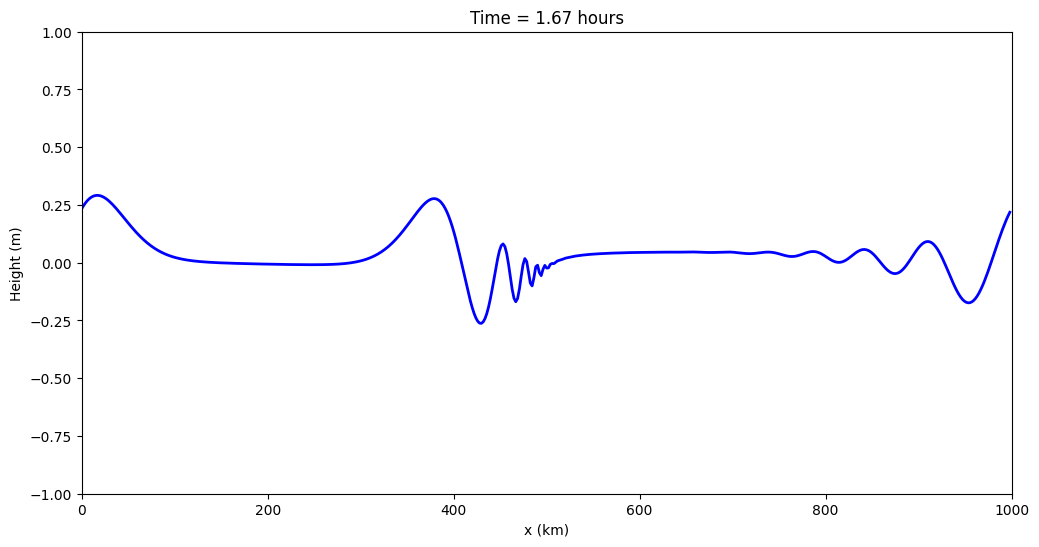

In [3]:
# create a figure and axes
fig = plt.figure(figsize=(12,6))

# Specify the axis limits and labels
plt.xlim((0, Lx / (1*kilometer)))
plt.ylim((-1, 1))
plt.xlabel('x (km)')
plt.ylabel('Height (m)')

# Create objects that will change during the animation
txt_title = plt.title('')
height, = plt.plot([], [], 'b', lw=2)

# Define an animation function
def drawframe(n):
    height.set_data(x/(1*kilometer), h_save[n,:])
    txt_title.set_text('Time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())


### 1.3 Student investigation
<a id='section1pt3'></a>
In the cells below, provide an expression for the expected wave speed and state any assumptions that are necessary to arrive at this. Then plot the wave speed from the output above and compare this with the expected value.

ADD EXPRESSION FOR EXPECTED WAVE SPEED AND EXPLANATION HERE

Consider a compressible gas. We have conservation of mass, which in 1D becomes
$$ \frac{\partial \rho}{\partial t} + u \frac{\partial \rho}{\partial x} + \rho\frac{\partial u}{\partial x} = 0\, .$$

We also have conservation of momentum, which in 1D is
$$ \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = -\frac{1}{\rho}\frac{\partial p}{\partial x}\, . $$

Assuming homentropic flow of an ideal gas, the sound speed is given by
$$ c^2(\rho) = \frac{\partial p}{\partial \rho}(\rho)\, .$$

Hence, conservation of momentum can be expressed as
$$ \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} +\frac{c^2}{\rho}\frac{\partial \rho}{\partial x} = 0\, . $$

Now, consider the 1D shallow water equations, which can be written in the form:
$$ \frac{\partial h}{\partial t} + u \frac{\partial(H+h)}{\partial x} + (H+h)\frac{\partial u}{\partial x} = 0\, ,$$
and
$$ \frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} + g\frac{\partial h}{\partial x} = 0\, .$$

Now, assuming $\frac{\partial H}{\partial t} = 0$ and $\frac{\partial H}{\partial x} << 1$, the 1D shallow water equations have exactly the same form as the equations for 1D flow in a perfect compressible flow. We identify $(H+h, u, g)$ in shallow water with $(\rho, u, \frac{c^2}{\rho})$ in a perfect gas. Therefore, the "sound speed" in the shallow water equations is
$$ c = \sqrt{g(H+h)}\, .$$

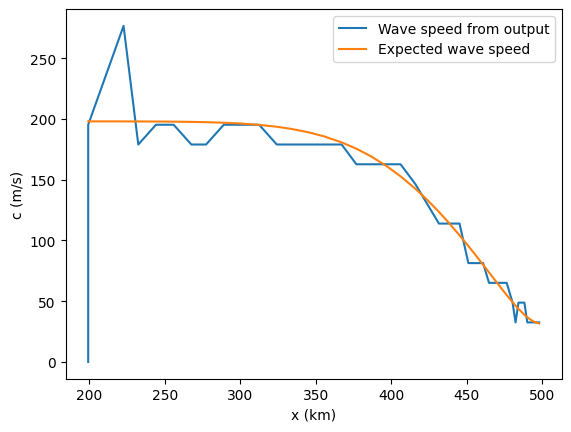

In [45]:
# CREATE FIGURES HERE

# Resting water depth
Hg = H['g']

# Peak position of the right moving wave
x_index_min = np.argmin(np.abs(x - x1))
peak_position = np.zeros(len(t_save))
peak_height = np.zeros(len(t_save))
resting_depth_at_peak_position = np.zeros(len(t_save))
for i in range(len(t_save)):
  peak_index = np.argmax(h_save[i,x_index_min:])
  peak_position[i] = x[peak_index+x_index_min]
  peak_height[i] = h_save[i,peak_index+x_index_min]
  resting_depth_at_peak_position[i] = Hg[peak_index+x_index_min]

end_time = np.argmin(np.abs(peak_position - x2))
time = t_save[0:end_time]
peak_position = peak_position[0:end_time]
peak_height = peak_height[0:end_time]
resting_depth_at_peak_position = resting_depth_at_peak_position[0:end_time]

# Output wave speed
c_output = np.zeros(len(time))
c_output[0] = (peak_position[1]-peak_position[0])/timestep # forward difference
c_output[-1] = (peak_position[-1]-peak_position[-2])/timestep # forward difference
for i in range(len(time)-2):
  c_output[i+1] = (peak_position[i+2] - peak_position[i])/(2*timestep) # Central difference


# Expected wave speed
c_expected = np.zeros(len(time))
for i in range(len(time)):
  c_expected[i] = np.sqrt(g*(resting_depth_at_peak_position[i]+peak_height[i]))

plt.plot(peak_position/(1*kilometer), c_output)
plt.plot(peak_position/(1*kilometer), c_expected)
plt.xlabel('x (km)')
plt.ylabel('c (m/s)')
plt.legend(['Wave speed from output','Expected wave speed'])


COMMENT ON RESULTS

The figure above shows a plot of the expected wave speed of the tsunami from the intial disturbance until it reaches the peak of the seamount. We also plot the wave speed from the output of the dedalus script. To do this, we notce from the movie that the tsunami is the highest peak until reaching the seamount, allowing us to identify its postion at each time interval. We use the forward difference
$$ c_{\mathrm{output}} = \frac{x_{\mathrm{peak}}(t+\Delta t) - x_{\mathrm{peak}}(t)}{\Delta t}\, ,$$
for the first and final time steps. We use the central difference
$$ c_{\mathrm{output}} = \frac{x_{\mathrm{peak}}(t+\Delta t) - x_{\mathrm{peak}}(t-\Delta t)}{2\Delta t}\, ,$$
for the intermediate time steps.

From the figure, we see that once the initial disturbance produces a right propagating wave, there is good agreement with the observed wave speed and the expected wave speed. As the tsunami approaches the seamount and the resting water depth decreases, the wave speed decreases. However, the wave speed from the output is not as smooth as the expected wave speed, which is a result of the discrete grid in $x$ only allowing discrete wave speeds for the constant time step.

## 2.  2D Shallow water equations

Now, let's see how things change if we move to two dimensions. The script below solves the 2D shallow water equations:

$$ \partial_t u + g \partial_x(h) = - u*\partial_x u - v*\partial_y u$$
$$ \partial_t u + g \partial_y(h) = - u*\partial_x v - v*\partial_y v$$
$$ \partial_t h + H (\partial_x(u) + \partial_y(v)) = -\partial_x(h*u) - \partial_y(h*v)$$

We will solve these equations in a square domain with periodic boundary conditions. We will again initialize with a Gaussian height disturbance and with no water motion, but this time in 2D:

$$ h=e^{-(x^2+y^2)/w^2} $$
$$ u=0 $$
$$ v=0 $$

### 2.1  Dedalus script to solve the 2D shallow water equations

In [182]:
# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Specify the simulation parameters
Lx = 1000 * kilometer # The domain size in x
Ly = 1000 * kilometer # The domain size in y
Nx = 64 # The number of gridpoints in x
Ny = 64 # The number of gridpoints in y
g = 9.81 * meter / second**2 # Gravitational acceleration
H = 4 * kilometer # Reference ocean depth
width = 100 * kilometer # Set the width of the initial Gaussian

timestep = 60 * second # Specify the timestep
stop_sim_time = 30 * minute # Specify the stopping time

timestepper = dedalus.RK222
max_timestep = 0.125

# Bases
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(-Lx/2, Lx/2), dealias=3/2)
ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(-Ly/2, Ly/2), dealias=3/2)

x, y = dist.local_grids(xbasis, ybasis)

# Fields
u = dist.Field(name='u', bases=(xbasis, ybasis))
v = dist.Field(name='v', bases=(xbasis, ybasis))
h = dist.Field(name='h', bases=(xbasis, ybasis))

# Initial conditions
h.change_scales(1) # Set values on regular grid
u.change_scales(1)
v.change_scales(1)
h['g'] = np.exp(-(x**2+y**2)/width**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
u['g'] = 0
v['g'] = 0

# Operators
dx = lambda a: dedalus.Differentiate(a, coords['x'])
dy = lambda a: dedalus.Differentiate(a, coords['y'])

# Problem
problem = dedalus.IVP([u, v, h], namespace=locals())
problem.add_equation("dt(u) + g*dx(h) = - u*dx(u) - v*dy(u)")
problem.add_equation("dt(v) + g*dy(h) = - u*dx(v) - v*dy(v)")
problem.add_equation("dt(h) + H*(dx(u) + dy(v)) = - dx(h*u) - dy(h*v)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=1*hour, max_writes=10)
snapshots.add_task(h, name='h')
snapshots.add_task(u, name='u')
snapshots.add_task(v, name='v')

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 1 == 0:
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save=np.array(h_save) # convert h_save to an np.array type to allow data slicing
t_save=np.array(t_save)

INFO:subsystems:Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 4s, Rate: 8.1e+00/s


2024-12-19 16:43:06,165 subsystems 0/1 INFO :: Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 4s, Rate: 8.1e+00/s


INFO:subsystems:Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 3s, Rate: 1.0e+01/s


2024-12-19 16:43:06,425 subsystems 0/1 INFO :: Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 3s, Rate: 1.0e+01/s


INFO:subsystems:Building subproblem matrices 8/32 (~25%) Elapsed: 1s, Remaining: 2s, Rate: 1.4e+01/s


2024-12-19 16:43:06,612 subsystems 0/1 INFO :: Building subproblem matrices 8/32 (~25%) Elapsed: 1s, Remaining: 2s, Rate: 1.4e+01/s


INFO:subsystems:Building subproblem matrices 12/32 (~38%) Elapsed: 1s, Remaining: 1s, Rate: 1.5e+01/s


2024-12-19 16:43:06,859 subsystems 0/1 INFO :: Building subproblem matrices 12/32 (~38%) Elapsed: 1s, Remaining: 1s, Rate: 1.5e+01/s


INFO:subsystems:Building subproblem matrices 16/32 (~50%) Elapsed: 1s, Remaining: 1s, Rate: 1.6e+01/s


2024-12-19 16:43:07,018 subsystems 0/1 INFO :: Building subproblem matrices 16/32 (~50%) Elapsed: 1s, Remaining: 1s, Rate: 1.6e+01/s


INFO:subsystems:Building subproblem matrices 20/32 (~62%) Elapsed: 1s, Remaining: 1s, Rate: 1.9e+01/s


2024-12-19 16:43:07,095 subsystems 0/1 INFO :: Building subproblem matrices 20/32 (~62%) Elapsed: 1s, Remaining: 1s, Rate: 1.9e+01/s


INFO:subsystems:Building subproblem matrices 24/32 (~75%) Elapsed: 1s, Remaining: 0s, Rate: 2.1e+01/s


2024-12-19 16:43:07,160 subsystems 0/1 INFO :: Building subproblem matrices 24/32 (~75%) Elapsed: 1s, Remaining: 0s, Rate: 2.1e+01/s


INFO:subsystems:Building subproblem matrices 28/32 (~88%) Elapsed: 1s, Remaining: 0s, Rate: 2.4e+01/s


2024-12-19 16:43:07,217 subsystems 0/1 INFO :: Building subproblem matrices 28/32 (~88%) Elapsed: 1s, Remaining: 0s, Rate: 2.4e+01/s


INFO:subsystems:Building subproblem matrices 32/32 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 2.6e+01/s


2024-12-19 16:43:07,289 subsystems 0/1 INFO :: Building subproblem matrices 32/32 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 2.6e+01/s


INFO:__main__:Starting main loop


2024-12-19 16:43:07,300 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2024-12-19 16:43:07,865 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 30


2024-12-19 16:43:07,871 solvers 0/1 INFO :: Final iteration: 30


INFO:solvers:Final sim time: 1800.0


2024-12-19 16:43:07,875 solvers 0/1 INFO :: Final sim time: 1800.0


INFO:solvers:Setup time (init - iter 0): 1.45 sec


2024-12-19 16:43:07,879 solvers 0/1 INFO :: Setup time (init - iter 0): 1.45 sec


INFO:solvers:Warmup time (iter 0-10): 0.2248 sec


2024-12-19 16:43:07,882 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.2248 sec


INFO:solvers:Run time (iter 10-end): 0.3349 sec


2024-12-19 16:43:07,885 solvers 0/1 INFO :: Run time (iter 10-end): 0.3349 sec


INFO:solvers:CPU time (iter 10-end): 9.302e-05 cpu-hr


2024-12-19 16:43:07,889 solvers 0/1 INFO :: CPU time (iter 10-end): 9.302e-05 cpu-hr


INFO:solvers:Speed: 1.422e+06 mode-stages/cpu-sec


2024-12-19 16:43:07,891 solvers 0/1 INFO :: Speed: 1.422e+06 mode-stages/cpu-sec


### 2.2  Plotting
The code below will make a movie of the height as a function of x and y

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2024-12-19 16:43:10,607 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpa9iloe72/temp.m4v


2024-12-19 16:43:10,617 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpa9iloe72/temp.m4v


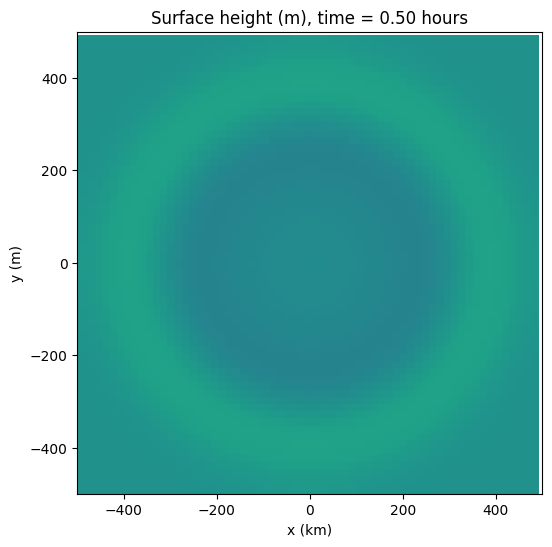

In [183]:
# create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the x and y coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))

# Define an animation function
def drawframe(n):
    plt.clf # clear the figure before plotting the next frame
    height = plt.pcolor(X/(1*kilometer), Y/(1*kilometer), h_save[n,:,:], vmin=-1, vmax=1)
    # Specify the axis limits and labels
    plt.xlim((-Lx/2 / (1*kilometer),Lx/2 / (1*kilometer)))
    plt.ylim((-Ly/2 / (1*kilometer),Ly/2 / (1*kilometer)))
    plt.xlabel('x (km)')
    plt.ylabel('y (m)')
    plt.title('Surface height (m), time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

### 2.3 Student investigation
<a id='section2pt3'></a>
Notice how the amplitude of the Tsunami wave decreases with distance from the source location. In the cell below, make a prediction for how the wave amplitude will vary as a function of distance from the origin (x=0, y=0) using conservation of energy. Then, make a plot or plots comparing your prediction for the wave amplitude compared with the results from the simulation.

Try out several different possible initial conditions for the surface height, $h$. How does the shape of the resulting waves change?

ADD PREDICTION OF WAVE AMPLITUDE HERE (a few sentences and/or equations)

Both the potential and kinetic energy densities are proportional to the square of the wave amplitude. Hence, the total energy (which is conserved) is proportional to the radial distance times the wave amplitude
$$ E \propto rh^2\, . $$
Therefore, we expect the wave amplitude to vary like
$$ h \propto r^{-1/2}\, . $$

The code below produces a plot of the wave amplitude as a funciton of the radial distance from the origin (since the initial Gaussian disturbance produces an axisymmetric wave, we reduce the problem to 1D, and simply plot the wave amplitude as a function of $x > 0$ for $y = 0$). We see that initially the peak is localised at the origin, but then produces a wave which propagates outwards.

To test our predicted power law relationship, we produce a log-log plot of wave amplitude against radial distance (for the positive values of $r$) and perfom a linear regression. The output matches well with out prediction, since the linear fit has a gradient of $-0.47 \approx -0.5$.

<ipython-input-126-144fccc74046>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  peak_position[i] = r[peak_index]


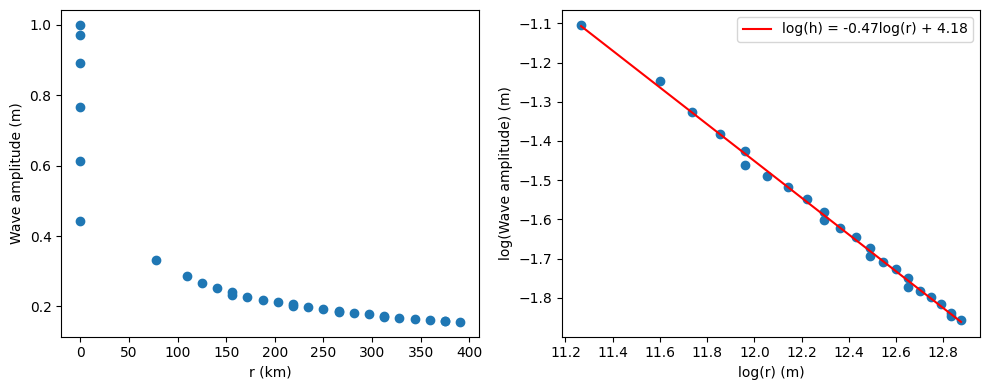

In [126]:
# ADD CODE TO MAKE PLOTS HERE

# radial symmetry so find h(r) with y=0 and x>0
y_index = np.argmin(np.abs(y))
x_min_index = np.argmin(np.abs(x))
h_r = h_save[:,x_min_index:,y_index]
r = x[x_min_index:]

peak_position = np.zeros(len(t_save))
peak_height = np.zeros(len(t_save))
for i in range(len(t_save)):
  peak_index = np.argmax(h_r[i,:])
  peak_position[i] = r[peak_index]
  peak_height[i] = h_r[i,peak_index]

fig, ax = plt.subplots(1,2,figsize = (10,4))
ax[0].scatter(peak_position/(1*kilometer),peak_height)
ax[0].set_xlabel('r (km)')
ax[0].set_ylabel('Wave amplitude (m)')

pos_indices = peak_position > 0
peak_position_pos = peak_position[pos_indices]
peak_height_pos = peak_height[pos_indices]
log_peak_position_pos = np.log(peak_position_pos)
log_peak_height_pos = np.log(peak_height_pos)
slope, intercept = np.polyfit(log_peak_position_pos, log_peak_height_pos, 1)
regression_line = slope * log_peak_position_pos + intercept

ax[1].scatter(log_peak_position_pos,log_peak_height_pos)
ax[1].plot(log_peak_position_pos,regression_line, color='r', label=f'log(h) = {slope:.2f}log(r) + {intercept:.2f}')
ax[1].set_xlabel('log(r) (m)')
ax[1].set_ylabel('log(Wave amplitude) (m)')
ax[1].legend()

fig.tight_layout()

ADD DISCUSSION HERE (~1 paragraph)

We can consider diferent forms of the intial condition for the surface height $h$. For example, a sinusoidal intial condition
$$ h = sin(x/(100\times\mathrm{kilometer}))\, .$$
The code block below sovles the shallow water equations with this sinusoidal inititial condition and plots $h$ as a function of $x$ (the disturbance is uniform in the $y$ direction for all time) for various times. We see oscillations of the sine wave with noise from the boundaries affecting the late time structure of the wave.

INFO:subsystems:Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 1s, Rate: 5.9e+01/s


2024-12-19 16:57:08,087 subsystems 0/1 INFO :: Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 1s, Rate: 5.9e+01/s


INFO:subsystems:Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 0s, Rate: 6.1e+01/s


2024-12-19 16:57:08,136 subsystems 0/1 INFO :: Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 0s, Rate: 6.1e+01/s


INFO:subsystems:Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 0s, Rate: 6.6e+01/s


2024-12-19 16:57:08,191 subsystems 0/1 INFO :: Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 0s, Rate: 6.6e+01/s


INFO:subsystems:Building subproblem matrices 12/32 (~38%) Elapsed: 0s, Remaining: 0s, Rate: 6.4e+01/s


2024-12-19 16:57:08,258 subsystems 0/1 INFO :: Building subproblem matrices 12/32 (~38%) Elapsed: 0s, Remaining: 0s, Rate: 6.4e+01/s


INFO:subsystems:Building subproblem matrices 16/32 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 6.5e+01/s


2024-12-19 16:57:08,316 subsystems 0/1 INFO :: Building subproblem matrices 16/32 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 6.5e+01/s


INFO:subsystems:Building subproblem matrices 20/32 (~62%) Elapsed: 0s, Remaining: 0s, Rate: 6.3e+01/s


2024-12-19 16:57:08,385 subsystems 0/1 INFO :: Building subproblem matrices 20/32 (~62%) Elapsed: 0s, Remaining: 0s, Rate: 6.3e+01/s


INFO:subsystems:Building subproblem matrices 24/32 (~75%) Elapsed: 0s, Remaining: 0s, Rate: 6.5e+01/s


2024-12-19 16:57:08,439 subsystems 0/1 INFO :: Building subproblem matrices 24/32 (~75%) Elapsed: 0s, Remaining: 0s, Rate: 6.5e+01/s


INFO:subsystems:Building subproblem matrices 28/32 (~88%) Elapsed: 0s, Remaining: 0s, Rate: 6.5e+01/s


2024-12-19 16:57:08,500 subsystems 0/1 INFO :: Building subproblem matrices 28/32 (~88%) Elapsed: 0s, Remaining: 0s, Rate: 6.5e+01/s


INFO:subsystems:Building subproblem matrices 32/32 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.5e+01/s


2024-12-19 16:57:08,563 subsystems 0/1 INFO :: Building subproblem matrices 32/32 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.5e+01/s


INFO:__main__:Starting main loop


2024-12-19 16:57:08,574 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2024-12-19 16:57:09,166 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 30


2024-12-19 16:57:09,172 solvers 0/1 INFO :: Final iteration: 30


INFO:solvers:Final sim time: 1800.0


2024-12-19 16:57:09,177 solvers 0/1 INFO :: Final sim time: 1800.0


INFO:solvers:Setup time (init - iter 0): 0.5423 sec


2024-12-19 16:57:09,180 solvers 0/1 INFO :: Setup time (init - iter 0): 0.5423 sec


INFO:solvers:Warmup time (iter 0-10): 0.2864 sec


2024-12-19 16:57:09,183 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.2864 sec


INFO:solvers:Run time (iter 10-end): 0.3008 sec


2024-12-19 16:57:09,186 solvers 0/1 INFO :: Run time (iter 10-end): 0.3008 sec


INFO:solvers:CPU time (iter 10-end): 8.355e-05 cpu-hr


2024-12-19 16:57:09,188 solvers 0/1 INFO :: CPU time (iter 10-end): 8.355e-05 cpu-hr


INFO:solvers:Speed: 1.583e+06 mode-stages/cpu-sec


2024-12-19 16:57:09,191 solvers 0/1 INFO :: Speed: 1.583e+06 mode-stages/cpu-sec


Text(0, 0.5, 'h (m)')

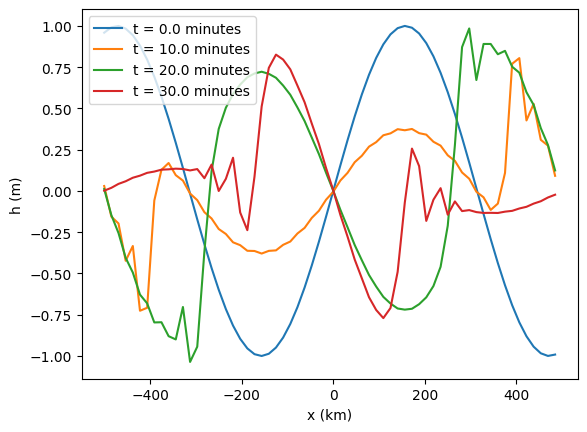

In [193]:
# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Specify the simulation parameters
Lx = 1000 * kilometer # The domain size in x
Ly = 1000 * kilometer # The domain size in y
Nx = 64 # The number of gridpoints in x
Ny = 64 # The number of gridpoints in y
g = 9.81 * meter / second**2 # Gravitational acceleration
H = 4 * kilometer # Reference ocean depth
width = 100 * kilometer # Set the width of the initial Gaussian

timestep = 60 * second # Specify the timestep
stop_sim_time = 30 * minute # Specify the stopping time

timestepper = dedalus.RK222
max_timestep = 0.125

# Bases
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(-Lx/2, Lx/2), dealias=3/2)
ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(-Ly/2, Ly/2), dealias=3/2)

x, y = dist.local_grids(xbasis, ybasis)

# Fields
u = dist.Field(name='u', bases=(xbasis, ybasis))
v = dist.Field(name='v', bases=(xbasis, ybasis))
h = dist.Field(name='h', bases=(xbasis, ybasis))

# Initial conditions
h.change_scales(1) # Set values on regular grid
u.change_scales(1)
v.change_scales(1)
h['g'] = np.sin(x/(100*kilometer))  # Initialize the dependent variable c with a sin function
u['g'] = 0
v['g'] = 0

# Operators
dx = lambda a: dedalus.Differentiate(a, coords['x'])
dy = lambda a: dedalus.Differentiate(a, coords['y'])

# Problem
problem = dedalus.IVP([u, v, h], namespace=locals())
problem.add_equation("dt(u) + g*dx(h) = - u*dx(u) - v*dy(u)")
problem.add_equation("dt(v) + g*dy(h) = - u*dx(v) - v*dy(v)")
problem.add_equation("dt(h) + H*(dx(u) + dy(v)) = - dx(h*u) - dy(h*v)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=1*hour, max_writes=10)
snapshots.add_task(h, name='h')
snapshots.add_task(u, name='u')
snapshots.add_task(v, name='v')

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 1 == 0:
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save=np.array(h_save) # convert h_save to an np.array type to allow data slicing
t_save=np.array(t_save)

h_x = h_save[:,:,0];

sample_times = [0, 10, 20, 30] # in minutes
for i in range(len(sample_times)):
  t_index = np.argmin(np.abs(t_save/(1*minute) - sample_times[i]))
  check_t = t_save[t_index]/(1*minute)
  plt.plot(x/(1*kilometer),h_x[t_index,:], label = f't = {check_t} minutes')
plt.legend()
plt.xlabel('x (km)')
plt.ylabel('h (m)')

## 3. Shallow water equations on a sphere

Of course the Earth isn't a flat plane. A great strength of Dedalus is its flexibility to solve equations in various geometries. The script below solves the 2D shallow water equations on a spherical shell, where the azimuth and colatitude are the independent variables. The colatitude is the complementary angle to the latitude such that the colatitude is $0^\circ$ at the North Pole, $90^\circ$ at the Equator, and $180^\circ$ at the South Pole. The spherical geometry also allows us to take into account the Earth's rotation in a realistic way.

Specifically, we will solve the following equations:
$$ \partial_t \mathbf{u} + g \nabla h + 2 \Omega \hat{\mathbf{z}} \times \mathbf{u} = -\mathbf{u} \cdot \nabla \mathbf{u} $$
$$ \partial_t + H \nabla \cdot \mathbf{u} = -\nabla \cdot (h \mathbf{u}) $$

where $\mathbf{u}$ is the velocity vector, $\Omega$ is the Earth's angular velocity (in radians per second), and $\hat{\mathbf{z}}$ is a unit vector aligned with the North Pole. Note that we have written the equations above in vector form. Dedalus includes vector calculus operators that make it very natural to solve equations like this without worrying about the particular form of the vector operators in a curvilinear coordinate system.

### 3.1  Dedalus script for 2D shallow water equations on a sphere

In [211]:
# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Parameters
Nphi = 128 # Number of gridpoints in phi (longitude)
Ntheta = 64 # Number of gridpoints in theta (colatitude)
R = 6.37122e3 * kilometer
Omega = 2 * np.pi / (1 * day) # Earth's angular velocity in radians per second
g = 9.80616 * meter / second**2 # Gravitational acceleration
H = 4 * kilometer # Depth of the ocean
width = 2*np.pi*10/360 # Width of the initial Gaussian in radians
phi0 = np.pi # Longitude of the initial Gaussian height perturbation in radians
theta0 = np.pi/4 # Colatitude of the initial Gaussian height perturbation in radians

timestep = 600 * second
stop_sim_time = 10 * day

# Bases
coords = dedalus.S2Coordinates('phi', 'theta')
dist = dedalus.Distributor(coords, dtype=np.float64)
basis = dedalus.SphereBasis(coords, (Nphi, Ntheta), radius=R, dealias=3/2, dtype=np.float64)

# Define the coordinates
phi, theta = dist.local_grids(basis) # Longitude and colatitude
lat = 360*(np.pi / 2 - theta)/(2*np.pi)  # latitude in degrees

# Fields
u = dist.VectorField(coords, name='u', bases=basis)
h = dist.Field(name='h', bases=basis)

# Operators
# First, create an operator to perform the cross product: "z x ", where z is the local vertical unit vector
# The "skew" operator performs a 90 degree rotation of a vector field,
# so that skew([u,v]) = [-v, u].  MulCosine multiplies by the cosine of the latitude
zcross = lambda A: dedalus.MulCosine(dedalus.skew(A))

# Set the initial conditions
h.change_scales(1) # Set values on regular grid
u.change_scales(1)
h['g'] = np.exp(-((phi-phi0)**2+(theta-theta0)**2)/width**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
# Set the initial velocity to zero
u['g'][0] = 0 # the x-component of the velocity
u['g'][1] = 0 # the y-component of the velocity

# Problem
problem = dedalus.IVP([u, h], namespace=locals())
problem.add_equation("dt(u) + g*grad(h) + 2*Omega*zcross(u) = - u@grad(u)")
problem.add_equation("dt(h) + H*div(u) = - div(h*u)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save = np.array(h_save)
t_save = np.array(t_save)

INFO:subsystems:Building subproblem matrices 1/63 (~2%) Elapsed: 0s, Remaining: 1s, Rate: 4.5e+01/s


2024-12-19 17:44:43,754 subsystems 0/1 INFO :: Building subproblem matrices 1/63 (~2%) Elapsed: 0s, Remaining: 1s, Rate: 4.5e+01/s


INFO:subsystems:Building subproblem matrices 7/63 (~11%) Elapsed: 0s, Remaining: 1s, Rate: 5.3e+01/s


2024-12-19 17:44:43,863 subsystems 0/1 INFO :: Building subproblem matrices 7/63 (~11%) Elapsed: 0s, Remaining: 1s, Rate: 5.3e+01/s


INFO:subsystems:Building subproblem matrices 14/63 (~22%) Elapsed: 0s, Remaining: 1s, Rate: 5.3e+01/s


2024-12-19 17:44:43,998 subsystems 0/1 INFO :: Building subproblem matrices 14/63 (~22%) Elapsed: 0s, Remaining: 1s, Rate: 5.3e+01/s


INFO:subsystems:Building subproblem matrices 21/63 (~33%) Elapsed: 0s, Remaining: 1s, Rate: 5.3e+01/s


2024-12-19 17:44:44,128 subsystems 0/1 INFO :: Building subproblem matrices 21/63 (~33%) Elapsed: 0s, Remaining: 1s, Rate: 5.3e+01/s


INFO:subsystems:Building subproblem matrices 28/63 (~44%) Elapsed: 1s, Remaining: 1s, Rate: 5.3e+01/s


2024-12-19 17:44:44,260 subsystems 0/1 INFO :: Building subproblem matrices 28/63 (~44%) Elapsed: 1s, Remaining: 1s, Rate: 5.3e+01/s


INFO:subsystems:Building subproblem matrices 35/63 (~56%) Elapsed: 1s, Remaining: 1s, Rate: 5.4e+01/s


2024-12-19 17:44:44,383 subsystems 0/1 INFO :: Building subproblem matrices 35/63 (~56%) Elapsed: 1s, Remaining: 1s, Rate: 5.4e+01/s


INFO:subsystems:Building subproblem matrices 42/63 (~67%) Elapsed: 1s, Remaining: 0s, Rate: 5.4e+01/s


2024-12-19 17:44:44,512 subsystems 0/1 INFO :: Building subproblem matrices 42/63 (~67%) Elapsed: 1s, Remaining: 0s, Rate: 5.4e+01/s


INFO:subsystems:Building subproblem matrices 49/63 (~78%) Elapsed: 1s, Remaining: 0s, Rate: 5.3e+01/s


2024-12-19 17:44:44,652 subsystems 0/1 INFO :: Building subproblem matrices 49/63 (~78%) Elapsed: 1s, Remaining: 0s, Rate: 5.3e+01/s


INFO:subsystems:Building subproblem matrices 56/63 (~89%) Elapsed: 1s, Remaining: 0s, Rate: 5.2e+01/s


2024-12-19 17:44:44,814 subsystems 0/1 INFO :: Building subproblem matrices 56/63 (~89%) Elapsed: 1s, Remaining: 0s, Rate: 5.2e+01/s


INFO:subsystems:Building subproblem matrices 63/63 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 5.2e+01/s


2024-12-19 17:44:44,944 subsystems 0/1 INFO :: Building subproblem matrices 63/63 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 5.2e+01/s


INFO:__main__:Starting main loop


2024-12-19 17:44:44,956 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=6.000000e+02, dt=6.000000e+02


2024-12-19 17:44:49,503 __main__ 0/1 INFO :: Iteration=1, Time=6.000000e+02, dt=6.000000e+02


INFO:__main__:Iteration=11, Time=6.600000e+03, dt=6.000000e+02


2024-12-19 17:44:50,417 __main__ 0/1 INFO :: Iteration=11, Time=6.600000e+03, dt=6.000000e+02


INFO:__main__:Iteration=21, Time=1.260000e+04, dt=6.000000e+02


2024-12-19 17:44:51,147 __main__ 0/1 INFO :: Iteration=21, Time=1.260000e+04, dt=6.000000e+02


INFO:__main__:Iteration=31, Time=1.860000e+04, dt=6.000000e+02


2024-12-19 17:44:51,917 __main__ 0/1 INFO :: Iteration=31, Time=1.860000e+04, dt=6.000000e+02


INFO:__main__:Iteration=41, Time=2.460000e+04, dt=6.000000e+02


2024-12-19 17:44:52,716 __main__ 0/1 INFO :: Iteration=41, Time=2.460000e+04, dt=6.000000e+02


INFO:__main__:Iteration=51, Time=3.060000e+04, dt=6.000000e+02


2024-12-19 17:44:53,557 __main__ 0/1 INFO :: Iteration=51, Time=3.060000e+04, dt=6.000000e+02


INFO:__main__:Iteration=61, Time=3.660000e+04, dt=6.000000e+02


2024-12-19 17:44:54,376 __main__ 0/1 INFO :: Iteration=61, Time=3.660000e+04, dt=6.000000e+02


INFO:__main__:Iteration=71, Time=4.260000e+04, dt=6.000000e+02


2024-12-19 17:44:54,977 __main__ 0/1 INFO :: Iteration=71, Time=4.260000e+04, dt=6.000000e+02


INFO:__main__:Iteration=81, Time=4.860000e+04, dt=6.000000e+02


2024-12-19 17:44:55,575 __main__ 0/1 INFO :: Iteration=81, Time=4.860000e+04, dt=6.000000e+02


INFO:__main__:Iteration=91, Time=5.460000e+04, dt=6.000000e+02


2024-12-19 17:44:56,195 __main__ 0/1 INFO :: Iteration=91, Time=5.460000e+04, dt=6.000000e+02


INFO:__main__:Iteration=101, Time=6.060000e+04, dt=6.000000e+02


2024-12-19 17:44:56,750 __main__ 0/1 INFO :: Iteration=101, Time=6.060000e+04, dt=6.000000e+02


INFO:__main__:Iteration=111, Time=6.660000e+04, dt=6.000000e+02


2024-12-19 17:44:57,311 __main__ 0/1 INFO :: Iteration=111, Time=6.660000e+04, dt=6.000000e+02


INFO:__main__:Iteration=121, Time=7.260000e+04, dt=6.000000e+02


2024-12-19 17:44:57,866 __main__ 0/1 INFO :: Iteration=121, Time=7.260000e+04, dt=6.000000e+02


INFO:__main__:Iteration=131, Time=7.860000e+04, dt=6.000000e+02


2024-12-19 17:44:58,412 __main__ 0/1 INFO :: Iteration=131, Time=7.860000e+04, dt=6.000000e+02


INFO:__main__:Iteration=141, Time=8.460000e+04, dt=6.000000e+02


2024-12-19 17:44:58,998 __main__ 0/1 INFO :: Iteration=141, Time=8.460000e+04, dt=6.000000e+02


INFO:__main__:Iteration=151, Time=9.060000e+04, dt=6.000000e+02


2024-12-19 17:44:59,561 __main__ 0/1 INFO :: Iteration=151, Time=9.060000e+04, dt=6.000000e+02


INFO:__main__:Iteration=161, Time=9.660000e+04, dt=6.000000e+02


2024-12-19 17:45:00,210 __main__ 0/1 INFO :: Iteration=161, Time=9.660000e+04, dt=6.000000e+02


INFO:__main__:Iteration=171, Time=1.026000e+05, dt=6.000000e+02


2024-12-19 17:45:00,795 __main__ 0/1 INFO :: Iteration=171, Time=1.026000e+05, dt=6.000000e+02


INFO:__main__:Iteration=181, Time=1.086000e+05, dt=6.000000e+02


2024-12-19 17:45:01,398 __main__ 0/1 INFO :: Iteration=181, Time=1.086000e+05, dt=6.000000e+02


INFO:__main__:Iteration=191, Time=1.146000e+05, dt=6.000000e+02


2024-12-19 17:45:02,081 __main__ 0/1 INFO :: Iteration=191, Time=1.146000e+05, dt=6.000000e+02


INFO:__main__:Iteration=201, Time=1.206000e+05, dt=6.000000e+02


2024-12-19 17:45:02,778 __main__ 0/1 INFO :: Iteration=201, Time=1.206000e+05, dt=6.000000e+02


INFO:__main__:Iteration=211, Time=1.266000e+05, dt=6.000000e+02


2024-12-19 17:45:03,618 __main__ 0/1 INFO :: Iteration=211, Time=1.266000e+05, dt=6.000000e+02


INFO:__main__:Iteration=221, Time=1.326000e+05, dt=6.000000e+02


2024-12-19 17:45:04,968 __main__ 0/1 INFO :: Iteration=221, Time=1.326000e+05, dt=6.000000e+02


INFO:__main__:Iteration=231, Time=1.386000e+05, dt=6.000000e+02


2024-12-19 17:45:06,071 __main__ 0/1 INFO :: Iteration=231, Time=1.386000e+05, dt=6.000000e+02


INFO:__main__:Iteration=241, Time=1.446000e+05, dt=6.000000e+02


2024-12-19 17:45:07,166 __main__ 0/1 INFO :: Iteration=241, Time=1.446000e+05, dt=6.000000e+02


INFO:__main__:Iteration=251, Time=1.506000e+05, dt=6.000000e+02


2024-12-19 17:45:08,384 __main__ 0/1 INFO :: Iteration=251, Time=1.506000e+05, dt=6.000000e+02


INFO:__main__:Iteration=261, Time=1.566000e+05, dt=6.000000e+02


2024-12-19 17:45:09,619 __main__ 0/1 INFO :: Iteration=261, Time=1.566000e+05, dt=6.000000e+02


INFO:__main__:Iteration=271, Time=1.626000e+05, dt=6.000000e+02


2024-12-19 17:45:10,693 __main__ 0/1 INFO :: Iteration=271, Time=1.626000e+05, dt=6.000000e+02


INFO:__main__:Iteration=281, Time=1.686000e+05, dt=6.000000e+02


2024-12-19 17:45:11,603 __main__ 0/1 INFO :: Iteration=281, Time=1.686000e+05, dt=6.000000e+02


INFO:__main__:Iteration=291, Time=1.746000e+05, dt=6.000000e+02


2024-12-19 17:45:12,193 __main__ 0/1 INFO :: Iteration=291, Time=1.746000e+05, dt=6.000000e+02


INFO:__main__:Iteration=301, Time=1.806000e+05, dt=6.000000e+02


2024-12-19 17:45:12,776 __main__ 0/1 INFO :: Iteration=301, Time=1.806000e+05, dt=6.000000e+02


INFO:__main__:Iteration=311, Time=1.866000e+05, dt=6.000000e+02


2024-12-19 17:45:13,474 __main__ 0/1 INFO :: Iteration=311, Time=1.866000e+05, dt=6.000000e+02


INFO:__main__:Iteration=321, Time=1.926000e+05, dt=6.000000e+02


2024-12-19 17:45:14,152 __main__ 0/1 INFO :: Iteration=321, Time=1.926000e+05, dt=6.000000e+02


INFO:__main__:Iteration=331, Time=1.986000e+05, dt=6.000000e+02


2024-12-19 17:45:15,227 __main__ 0/1 INFO :: Iteration=331, Time=1.986000e+05, dt=6.000000e+02


INFO:__main__:Iteration=341, Time=2.046000e+05, dt=6.000000e+02


2024-12-19 17:45:15,800 __main__ 0/1 INFO :: Iteration=341, Time=2.046000e+05, dt=6.000000e+02


INFO:__main__:Iteration=351, Time=2.106000e+05, dt=6.000000e+02


2024-12-19 17:45:16,793 __main__ 0/1 INFO :: Iteration=351, Time=2.106000e+05, dt=6.000000e+02


INFO:__main__:Iteration=361, Time=2.166000e+05, dt=6.000000e+02


2024-12-19 17:45:17,497 __main__ 0/1 INFO :: Iteration=361, Time=2.166000e+05, dt=6.000000e+02


INFO:__main__:Iteration=371, Time=2.226000e+05, dt=6.000000e+02


2024-12-19 17:45:18,349 __main__ 0/1 INFO :: Iteration=371, Time=2.226000e+05, dt=6.000000e+02


INFO:__main__:Iteration=381, Time=2.286000e+05, dt=6.000000e+02


2024-12-19 17:45:19,527 __main__ 0/1 INFO :: Iteration=381, Time=2.286000e+05, dt=6.000000e+02


INFO:__main__:Iteration=391, Time=2.346000e+05, dt=6.000000e+02


2024-12-19 17:45:20,627 __main__ 0/1 INFO :: Iteration=391, Time=2.346000e+05, dt=6.000000e+02


INFO:__main__:Iteration=401, Time=2.406000e+05, dt=6.000000e+02


2024-12-19 17:45:21,575 __main__ 0/1 INFO :: Iteration=401, Time=2.406000e+05, dt=6.000000e+02


INFO:__main__:Iteration=411, Time=2.466000e+05, dt=6.000000e+02


2024-12-19 17:45:22,976 __main__ 0/1 INFO :: Iteration=411, Time=2.466000e+05, dt=6.000000e+02


INFO:__main__:Iteration=421, Time=2.526000e+05, dt=6.000000e+02


2024-12-19 17:45:23,592 __main__ 0/1 INFO :: Iteration=421, Time=2.526000e+05, dt=6.000000e+02


INFO:__main__:Iteration=431, Time=2.586000e+05, dt=6.000000e+02


2024-12-19 17:45:24,191 __main__ 0/1 INFO :: Iteration=431, Time=2.586000e+05, dt=6.000000e+02


INFO:__main__:Iteration=441, Time=2.646000e+05, dt=6.000000e+02


2024-12-19 17:45:24,775 __main__ 0/1 INFO :: Iteration=441, Time=2.646000e+05, dt=6.000000e+02


INFO:__main__:Iteration=451, Time=2.706000e+05, dt=6.000000e+02


2024-12-19 17:45:25,891 __main__ 0/1 INFO :: Iteration=451, Time=2.706000e+05, dt=6.000000e+02


INFO:__main__:Iteration=461, Time=2.766000e+05, dt=6.000000e+02


2024-12-19 17:45:26,463 __main__ 0/1 INFO :: Iteration=461, Time=2.766000e+05, dt=6.000000e+02


INFO:__main__:Iteration=471, Time=2.826000e+05, dt=6.000000e+02


2024-12-19 17:45:27,407 __main__ 0/1 INFO :: Iteration=471, Time=2.826000e+05, dt=6.000000e+02


INFO:__main__:Iteration=481, Time=2.886000e+05, dt=6.000000e+02


2024-12-19 17:45:28,540 __main__ 0/1 INFO :: Iteration=481, Time=2.886000e+05, dt=6.000000e+02


INFO:__main__:Iteration=491, Time=2.946000e+05, dt=6.000000e+02


2024-12-19 17:45:29,721 __main__ 0/1 INFO :: Iteration=491, Time=2.946000e+05, dt=6.000000e+02


INFO:__main__:Iteration=501, Time=3.006000e+05, dt=6.000000e+02


2024-12-19 17:45:30,423 __main__ 0/1 INFO :: Iteration=501, Time=3.006000e+05, dt=6.000000e+02


INFO:__main__:Iteration=511, Time=3.066000e+05, dt=6.000000e+02


2024-12-19 17:45:30,999 __main__ 0/1 INFO :: Iteration=511, Time=3.066000e+05, dt=6.000000e+02


INFO:__main__:Iteration=521, Time=3.126000e+05, dt=6.000000e+02


2024-12-19 17:45:31,550 __main__ 0/1 INFO :: Iteration=521, Time=3.126000e+05, dt=6.000000e+02


INFO:__main__:Iteration=531, Time=3.186000e+05, dt=6.000000e+02


2024-12-19 17:45:32,104 __main__ 0/1 INFO :: Iteration=531, Time=3.186000e+05, dt=6.000000e+02


INFO:__main__:Iteration=541, Time=3.246000e+05, dt=6.000000e+02


2024-12-19 17:45:32,668 __main__ 0/1 INFO :: Iteration=541, Time=3.246000e+05, dt=6.000000e+02


INFO:__main__:Iteration=551, Time=3.306000e+05, dt=6.000000e+02


2024-12-19 17:45:33,399 __main__ 0/1 INFO :: Iteration=551, Time=3.306000e+05, dt=6.000000e+02


INFO:__main__:Iteration=561, Time=3.366000e+05, dt=6.000000e+02


2024-12-19 17:45:34,795 __main__ 0/1 INFO :: Iteration=561, Time=3.366000e+05, dt=6.000000e+02


INFO:__main__:Iteration=571, Time=3.426000e+05, dt=6.000000e+02


2024-12-19 17:45:36,461 __main__ 0/1 INFO :: Iteration=571, Time=3.426000e+05, dt=6.000000e+02


INFO:__main__:Iteration=581, Time=3.486000e+05, dt=6.000000e+02


2024-12-19 17:45:37,392 __main__ 0/1 INFO :: Iteration=581, Time=3.486000e+05, dt=6.000000e+02


INFO:__main__:Iteration=591, Time=3.546000e+05, dt=6.000000e+02


2024-12-19 17:45:38,082 __main__ 0/1 INFO :: Iteration=591, Time=3.546000e+05, dt=6.000000e+02


INFO:__main__:Iteration=601, Time=3.606000e+05, dt=6.000000e+02


2024-12-19 17:45:38,818 __main__ 0/1 INFO :: Iteration=601, Time=3.606000e+05, dt=6.000000e+02


INFO:__main__:Iteration=611, Time=3.666000e+05, dt=6.000000e+02


2024-12-19 17:45:39,647 __main__ 0/1 INFO :: Iteration=611, Time=3.666000e+05, dt=6.000000e+02


INFO:__main__:Iteration=621, Time=3.726000e+05, dt=6.000000e+02


2024-12-19 17:45:40,610 __main__ 0/1 INFO :: Iteration=621, Time=3.726000e+05, dt=6.000000e+02


INFO:__main__:Iteration=631, Time=3.786000e+05, dt=6.000000e+02


2024-12-19 17:45:41,180 __main__ 0/1 INFO :: Iteration=631, Time=3.786000e+05, dt=6.000000e+02


INFO:__main__:Iteration=641, Time=3.846000e+05, dt=6.000000e+02


2024-12-19 17:45:41,774 __main__ 0/1 INFO :: Iteration=641, Time=3.846000e+05, dt=6.000000e+02


INFO:__main__:Iteration=651, Time=3.906000e+05, dt=6.000000e+02


2024-12-19 17:45:42,331 __main__ 0/1 INFO :: Iteration=651, Time=3.906000e+05, dt=6.000000e+02


INFO:__main__:Iteration=661, Time=3.966000e+05, dt=6.000000e+02


2024-12-19 17:45:42,883 __main__ 0/1 INFO :: Iteration=661, Time=3.966000e+05, dt=6.000000e+02


INFO:__main__:Iteration=671, Time=4.026000e+05, dt=6.000000e+02


2024-12-19 17:45:43,488 __main__ 0/1 INFO :: Iteration=671, Time=4.026000e+05, dt=6.000000e+02


INFO:__main__:Iteration=681, Time=4.086000e+05, dt=6.000000e+02


2024-12-19 17:45:44,068 __main__ 0/1 INFO :: Iteration=681, Time=4.086000e+05, dt=6.000000e+02


INFO:__main__:Iteration=691, Time=4.146000e+05, dt=6.000000e+02


2024-12-19 17:45:44,639 __main__ 0/1 INFO :: Iteration=691, Time=4.146000e+05, dt=6.000000e+02


INFO:__main__:Iteration=701, Time=4.206000e+05, dt=6.000000e+02


2024-12-19 17:45:45,208 __main__ 0/1 INFO :: Iteration=701, Time=4.206000e+05, dt=6.000000e+02


INFO:__main__:Iteration=711, Time=4.266000e+05, dt=6.000000e+02


2024-12-19 17:45:45,796 __main__ 0/1 INFO :: Iteration=711, Time=4.266000e+05, dt=6.000000e+02


INFO:__main__:Iteration=721, Time=4.326000e+05, dt=6.000000e+02


2024-12-19 17:45:46,371 __main__ 0/1 INFO :: Iteration=721, Time=4.326000e+05, dt=6.000000e+02


INFO:__main__:Iteration=731, Time=4.386000e+05, dt=6.000000e+02


2024-12-19 17:45:46,977 __main__ 0/1 INFO :: Iteration=731, Time=4.386000e+05, dt=6.000000e+02


INFO:__main__:Iteration=741, Time=4.446000e+05, dt=6.000000e+02


2024-12-19 17:45:47,688 __main__ 0/1 INFO :: Iteration=741, Time=4.446000e+05, dt=6.000000e+02


INFO:__main__:Iteration=751, Time=4.506000e+05, dt=6.000000e+02


2024-12-19 17:45:48,791 __main__ 0/1 INFO :: Iteration=751, Time=4.506000e+05, dt=6.000000e+02


INFO:__main__:Iteration=761, Time=4.566000e+05, dt=6.000000e+02


2024-12-19 17:45:49,748 __main__ 0/1 INFO :: Iteration=761, Time=4.566000e+05, dt=6.000000e+02


INFO:__main__:Iteration=771, Time=4.626000e+05, dt=6.000000e+02


2024-12-19 17:45:50,639 __main__ 0/1 INFO :: Iteration=771, Time=4.626000e+05, dt=6.000000e+02


INFO:__main__:Iteration=781, Time=4.686000e+05, dt=6.000000e+02


2024-12-19 17:45:51,429 __main__ 0/1 INFO :: Iteration=781, Time=4.686000e+05, dt=6.000000e+02


INFO:__main__:Iteration=791, Time=4.746000e+05, dt=6.000000e+02


2024-12-19 17:45:52,467 __main__ 0/1 INFO :: Iteration=791, Time=4.746000e+05, dt=6.000000e+02


INFO:__main__:Iteration=801, Time=4.806000e+05, dt=6.000000e+02


2024-12-19 17:45:53,045 __main__ 0/1 INFO :: Iteration=801, Time=4.806000e+05, dt=6.000000e+02


INFO:__main__:Iteration=811, Time=4.866000e+05, dt=6.000000e+02


2024-12-19 17:45:53,670 __main__ 0/1 INFO :: Iteration=811, Time=4.866000e+05, dt=6.000000e+02


INFO:__main__:Iteration=821, Time=4.926000e+05, dt=6.000000e+02


2024-12-19 17:45:54,279 __main__ 0/1 INFO :: Iteration=821, Time=4.926000e+05, dt=6.000000e+02


INFO:__main__:Iteration=831, Time=4.986000e+05, dt=6.000000e+02


2024-12-19 17:45:54,896 __main__ 0/1 INFO :: Iteration=831, Time=4.986000e+05, dt=6.000000e+02


INFO:__main__:Iteration=841, Time=5.046000e+05, dt=6.000000e+02


2024-12-19 17:45:56,032 __main__ 0/1 INFO :: Iteration=841, Time=5.046000e+05, dt=6.000000e+02


INFO:__main__:Iteration=851, Time=5.106000e+05, dt=6.000000e+02


2024-12-19 17:45:57,283 __main__ 0/1 INFO :: Iteration=851, Time=5.106000e+05, dt=6.000000e+02


INFO:__main__:Iteration=861, Time=5.166000e+05, dt=6.000000e+02


2024-12-19 17:45:57,937 __main__ 0/1 INFO :: Iteration=861, Time=5.166000e+05, dt=6.000000e+02


INFO:__main__:Iteration=871, Time=5.226000e+05, dt=6.000000e+02


2024-12-19 17:45:58,504 __main__ 0/1 INFO :: Iteration=871, Time=5.226000e+05, dt=6.000000e+02


INFO:__main__:Iteration=881, Time=5.286000e+05, dt=6.000000e+02


2024-12-19 17:45:59,241 __main__ 0/1 INFO :: Iteration=881, Time=5.286000e+05, dt=6.000000e+02


INFO:__main__:Iteration=891, Time=5.346000e+05, dt=6.000000e+02


2024-12-19 17:45:59,790 __main__ 0/1 INFO :: Iteration=891, Time=5.346000e+05, dt=6.000000e+02


INFO:__main__:Iteration=901, Time=5.406000e+05, dt=6.000000e+02


2024-12-19 17:46:00,415 __main__ 0/1 INFO :: Iteration=901, Time=5.406000e+05, dt=6.000000e+02


INFO:__main__:Iteration=911, Time=5.466000e+05, dt=6.000000e+02


2024-12-19 17:46:01,000 __main__ 0/1 INFO :: Iteration=911, Time=5.466000e+05, dt=6.000000e+02


INFO:__main__:Iteration=921, Time=5.526000e+05, dt=6.000000e+02


2024-12-19 17:46:01,897 __main__ 0/1 INFO :: Iteration=921, Time=5.526000e+05, dt=6.000000e+02


INFO:__main__:Iteration=931, Time=5.586000e+05, dt=6.000000e+02


2024-12-19 17:46:02,811 __main__ 0/1 INFO :: Iteration=931, Time=5.586000e+05, dt=6.000000e+02


INFO:__main__:Iteration=941, Time=5.646000e+05, dt=6.000000e+02


2024-12-19 17:46:04,304 __main__ 0/1 INFO :: Iteration=941, Time=5.646000e+05, dt=6.000000e+02


INFO:__main__:Iteration=951, Time=5.706000e+05, dt=6.000000e+02


2024-12-19 17:46:05,291 __main__ 0/1 INFO :: Iteration=951, Time=5.706000e+05, dt=6.000000e+02


INFO:__main__:Iteration=961, Time=5.766000e+05, dt=6.000000e+02


2024-12-19 17:46:06,116 __main__ 0/1 INFO :: Iteration=961, Time=5.766000e+05, dt=6.000000e+02


INFO:__main__:Iteration=971, Time=5.826000e+05, dt=6.000000e+02


2024-12-19 17:46:06,889 __main__ 0/1 INFO :: Iteration=971, Time=5.826000e+05, dt=6.000000e+02


INFO:__main__:Iteration=981, Time=5.886000e+05, dt=6.000000e+02


2024-12-19 17:46:07,664 __main__ 0/1 INFO :: Iteration=981, Time=5.886000e+05, dt=6.000000e+02


INFO:__main__:Iteration=991, Time=5.946000e+05, dt=6.000000e+02


2024-12-19 17:46:08,255 __main__ 0/1 INFO :: Iteration=991, Time=5.946000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1001, Time=6.006000e+05, dt=6.000000e+02


2024-12-19 17:46:09,011 __main__ 0/1 INFO :: Iteration=1001, Time=6.006000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1011, Time=6.066000e+05, dt=6.000000e+02


2024-12-19 17:46:09,611 __main__ 0/1 INFO :: Iteration=1011, Time=6.066000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1021, Time=6.126000e+05, dt=6.000000e+02


2024-12-19 17:46:10,314 __main__ 0/1 INFO :: Iteration=1021, Time=6.126000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1031, Time=6.186000e+05, dt=6.000000e+02


2024-12-19 17:46:11,066 __main__ 0/1 INFO :: Iteration=1031, Time=6.186000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1041, Time=6.246000e+05, dt=6.000000e+02


2024-12-19 17:46:11,738 __main__ 0/1 INFO :: Iteration=1041, Time=6.246000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1051, Time=6.306000e+05, dt=6.000000e+02


2024-12-19 17:46:12,732 __main__ 0/1 INFO :: Iteration=1051, Time=6.306000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1061, Time=6.366000e+05, dt=6.000000e+02


2024-12-19 17:46:13,711 __main__ 0/1 INFO :: Iteration=1061, Time=6.366000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1071, Time=6.426000e+05, dt=6.000000e+02


2024-12-19 17:46:14,311 __main__ 0/1 INFO :: Iteration=1071, Time=6.426000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1081, Time=6.486000e+05, dt=6.000000e+02


2024-12-19 17:46:15,384 __main__ 0/1 INFO :: Iteration=1081, Time=6.486000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1091, Time=6.546000e+05, dt=6.000000e+02


2024-12-19 17:46:16,365 __main__ 0/1 INFO :: Iteration=1091, Time=6.546000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1101, Time=6.606000e+05, dt=6.000000e+02


2024-12-19 17:46:18,379 __main__ 0/1 INFO :: Iteration=1101, Time=6.606000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1111, Time=6.666000e+05, dt=6.000000e+02


2024-12-19 17:46:19,615 __main__ 0/1 INFO :: Iteration=1111, Time=6.666000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1121, Time=6.726000e+05, dt=6.000000e+02


2024-12-19 17:46:20,446 __main__ 0/1 INFO :: Iteration=1121, Time=6.726000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1131, Time=6.786000e+05, dt=6.000000e+02


2024-12-19 17:46:21,029 __main__ 0/1 INFO :: Iteration=1131, Time=6.786000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1141, Time=6.846000e+05, dt=6.000000e+02


2024-12-19 17:46:21,599 __main__ 0/1 INFO :: Iteration=1141, Time=6.846000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1151, Time=6.906000e+05, dt=6.000000e+02


2024-12-19 17:46:22,222 __main__ 0/1 INFO :: Iteration=1151, Time=6.906000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1161, Time=6.966000e+05, dt=6.000000e+02


2024-12-19 17:46:22,783 __main__ 0/1 INFO :: Iteration=1161, Time=6.966000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1171, Time=7.026000e+05, dt=6.000000e+02


2024-12-19 17:46:23,361 __main__ 0/1 INFO :: Iteration=1171, Time=7.026000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1181, Time=7.086000e+05, dt=6.000000e+02


2024-12-19 17:46:23,950 __main__ 0/1 INFO :: Iteration=1181, Time=7.086000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1191, Time=7.146000e+05, dt=6.000000e+02


2024-12-19 17:46:24,551 __main__ 0/1 INFO :: Iteration=1191, Time=7.146000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1201, Time=7.206000e+05, dt=6.000000e+02


2024-12-19 17:46:25,184 __main__ 0/1 INFO :: Iteration=1201, Time=7.206000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1211, Time=7.266000e+05, dt=6.000000e+02


2024-12-19 17:46:25,846 __main__ 0/1 INFO :: Iteration=1211, Time=7.266000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1221, Time=7.326000e+05, dt=6.000000e+02


2024-12-19 17:46:26,465 __main__ 0/1 INFO :: Iteration=1221, Time=7.326000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1231, Time=7.386000e+05, dt=6.000000e+02


2024-12-19 17:46:27,052 __main__ 0/1 INFO :: Iteration=1231, Time=7.386000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1241, Time=7.446000e+05, dt=6.000000e+02


2024-12-19 17:46:27,602 __main__ 0/1 INFO :: Iteration=1241, Time=7.446000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1251, Time=7.506000e+05, dt=6.000000e+02


2024-12-19 17:46:28,157 __main__ 0/1 INFO :: Iteration=1251, Time=7.506000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1261, Time=7.566000e+05, dt=6.000000e+02


2024-12-19 17:46:28,730 __main__ 0/1 INFO :: Iteration=1261, Time=7.566000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1271, Time=7.626000e+05, dt=6.000000e+02


2024-12-19 17:46:29,310 __main__ 0/1 INFO :: Iteration=1271, Time=7.626000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1281, Time=7.686000e+05, dt=6.000000e+02


2024-12-19 17:46:30,177 __main__ 0/1 INFO :: Iteration=1281, Time=7.686000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1291, Time=7.746000e+05, dt=6.000000e+02


2024-12-19 17:46:31,251 __main__ 0/1 INFO :: Iteration=1291, Time=7.746000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1301, Time=7.806000e+05, dt=6.000000e+02


2024-12-19 17:46:32,096 __main__ 0/1 INFO :: Iteration=1301, Time=7.806000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1311, Time=7.866000e+05, dt=6.000000e+02


2024-12-19 17:46:33,128 __main__ 0/1 INFO :: Iteration=1311, Time=7.866000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1321, Time=7.926000e+05, dt=6.000000e+02


2024-12-19 17:46:34,249 __main__ 0/1 INFO :: Iteration=1321, Time=7.926000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1331, Time=7.986000e+05, dt=6.000000e+02


2024-12-19 17:46:35,108 __main__ 0/1 INFO :: Iteration=1331, Time=7.986000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1341, Time=8.046000e+05, dt=6.000000e+02


2024-12-19 17:46:35,955 __main__ 0/1 INFO :: Iteration=1341, Time=8.046000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1351, Time=8.106000e+05, dt=6.000000e+02


2024-12-19 17:46:36,700 __main__ 0/1 INFO :: Iteration=1351, Time=8.106000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1361, Time=8.166000e+05, dt=6.000000e+02


2024-12-19 17:46:37,422 __main__ 0/1 INFO :: Iteration=1361, Time=8.166000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1371, Time=8.226000e+05, dt=6.000000e+02


2024-12-19 17:46:38,303 __main__ 0/1 INFO :: Iteration=1371, Time=8.226000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1381, Time=8.286000e+05, dt=6.000000e+02


2024-12-19 17:46:38,960 __main__ 0/1 INFO :: Iteration=1381, Time=8.286000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1391, Time=8.346000e+05, dt=6.000000e+02


2024-12-19 17:46:39,571 __main__ 0/1 INFO :: Iteration=1391, Time=8.346000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1401, Time=8.406000e+05, dt=6.000000e+02


2024-12-19 17:46:40,359 __main__ 0/1 INFO :: Iteration=1401, Time=8.406000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1411, Time=8.466000e+05, dt=6.000000e+02


2024-12-19 17:46:41,004 __main__ 0/1 INFO :: Iteration=1411, Time=8.466000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1421, Time=8.526000e+05, dt=6.000000e+02


2024-12-19 17:46:41,583 __main__ 0/1 INFO :: Iteration=1421, Time=8.526000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1431, Time=8.586000e+05, dt=6.000000e+02


2024-12-19 17:46:42,165 __main__ 0/1 INFO :: Iteration=1431, Time=8.586000e+05, dt=6.000000e+02


INFO:solvers:Simulation stop time reached.


2024-12-19 17:46:42,666 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 1440


2024-12-19 17:46:42,676 solvers 0/1 INFO :: Final iteration: 1440


INFO:solvers:Final sim time: 864000.0


2024-12-19 17:46:42,681 solvers 0/1 INFO :: Final sim time: 864000.0


INFO:solvers:Setup time (init - iter 0): 4.834 sec


2024-12-19 17:46:42,685 solvers 0/1 INFO :: Setup time (init - iter 0): 4.834 sec


INFO:solvers:Warmup time (iter 0-10): 1.844 sec


2024-12-19 17:46:42,691 solvers 0/1 INFO :: Warmup time (iter 0-10): 1.844 sec


INFO:solvers:Run time (iter 10-end): 112.3 sec


2024-12-19 17:46:42,693 solvers 0/1 INFO :: Run time (iter 10-end): 112.3 sec


INFO:solvers:CPU time (iter 10-end): 0.0312 cpu-hr


2024-12-19 17:46:42,695 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0312 cpu-hr


INFO:solvers:Speed: 3.079e+05 mode-stages/cpu-sec


2024-12-19 17:46:42,697 solvers 0/1 INFO :: Speed: 3.079e+05 mode-stages/cpu-sec


### 3.2  Plotting
The code below will make a movie of the height as a function of x and y

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2024-12-19 17:40:30,965 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp9pcpr3gf/temp.m4v


2024-12-19 17:40:30,972 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp9pcpr3gf/temp.m4v


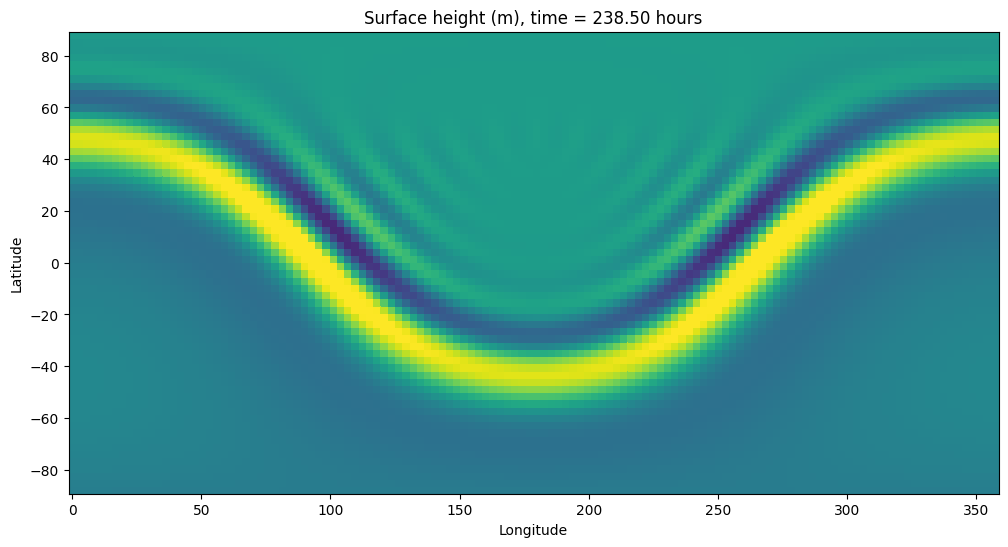

In [210]:
# create a figure and axes
fig = plt.figure(figsize=(12,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(np.pi/2 - theta)*360/2/np.pi, np.squeeze(phi)*360/2/np.pi)

# Define an animation function
def drawframe(n):
    plt.clf()
    height = plt.pcolor(Y, X, h_save[n,:,:], vmin=-0.1, vmax=0.1)
    # Specify the axis limits and labels
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Surface height (m), time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

### 3.3 Student investigation
<a id='section3pt3'></a>
Create a virtual tide gauge by sampling the height at a point at a latitude of 45ºN and longitude of 90ºW and plot the timeseries of the height at this point in the cells below. Notice that as the gravity waves propagate around the Earth, their shape changes. Discuss physical mechanisms that might cause the shape of the wave to change as the wave propagates.

Text(0.5, 1.0, 'Virtual tide gauge at (the closest grid point to) $45^{\\circ}$N, $90^{\\circ}$W')

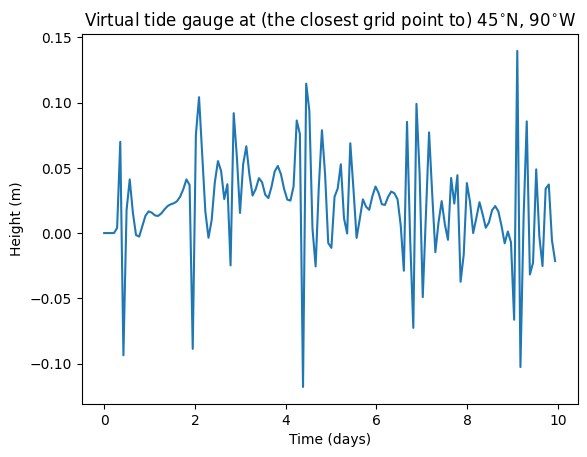

In [208]:
# This script produces a virtual tide gauge by sampling the height at a latitude of 45degN and longitude of 90degW
phi_sample = np.pi/2
theta_sample = np.pi/4

phi_index = np.argmin(np.abs(phi - phi_sample))
theta_index = np.argmin(np.abs(theta - theta_sample))

h_sample = h_save[:,phi_index,theta_index]

plt.plot(t_save/(1*day),h_sample)
plt.xlabel('Time (days)')
plt.ylabel('Height (m)')
plt.title('Virtual tide gauge at (the closest grid point to) $45^{\circ}$N, $90^{\circ}$W')

ADD PLOTS AND DISCUSSION HERE

The plot above shows the timeseries of the surface height at the point at a latitude of 45ºN and longitude of 90ºW.

In our simulation, we observe that as the gravity waves propagate around the Earth, their shape changes over time. However, by setting the angular velocity of the Earth, $\Omega$, to zero, we see that the wave no longer deforms. Instead, it oscillates symmetrically back and forth between opposite sides of the Earth, mainting its shape. This suggests that the Coriolos force, which arises in the rotating reference frame is the primary physical mechanism responsible for shaping the wave's evolution.

In the simulation above, the Tsunami wave travels around the planet many times. In reality, the waves will partially dissipate when they reach shorelines. In the spherical shallow water equation code above (or in a new code block below), add a forcing term to the shallow water equations that damps the waves for longitudes larger than $\pm 90^\circ$. Specifically, add a forcing function to the right hand side of the height equation of the following form:

$$ - (1/\tau) f(\phi) h$$

where

$$ f(\phi) = \frac{1}{2}\left(1+tanh\left(\frac{\phi-3\pi/2}{\pi/10}\right)\right) + \frac{1}{2}\left(1-tanh\left(\frac{\phi-\pi/2}{\pi/10}\right)\right) $$

and $\phi$ is the co-latitude in radians and $\tau$ is a damping timescale. A timescale of $\tau=0.1$ days should be sufficient to damp the waves.

With this damping term active, much more slowly propagating waves should be visible. These are shallow water Rossby waves. Estimate the east/west phase speed of these Rossby waves and compare them with the phase speed that you can infer from the simulation by plotting the height, $h$, as a function of longitude and time. Discuss the spatial structure of the Rossby waves and any discrepancies that you see between your estimated and measured phase speeds.

In [ ]:
# ADD CODE HERE TO SOLVE THE SHALLOW WATER EQUATIONS WITH DAMPING.
# YOU CAN START BY COPYING THE CODE ABOVE AND PASTING IT HERE

## 4. Optional further investigations

* In the example of the shallow water equations on a sphere, introduce bathymetry by making $H$ a function of latitude and longitude. Make sure that you modify the equations in Dedalus appropriately. How do the waves behave when they encounter shallow water (e.g. a localized seamount)?

* It is quite difficult to simulate changing sea level (sometimes called wetting and drying), which is why the examples above do not include land. However, we can estimate the distance that a Tsunami will propagate using physical and dimensional arguments. Consider, for example, a flat, sloping beach. In the absence of energy dissipation, estimate the distance that a wave will propagate onshore. How could you modify this estimate to include energy dissipation (or drag)?